In [136]:
import rasterio
from rasterio.coords import BoundingBox
from rasterio import windows
from rasterio import warp
from rasterio import mask
import numpy as np
import folium
import matplotlib.pyplot as plt
import rasterio.plot as plot
from matplotlib.patches import Rectangle

import geopandas
import fiona
import rasterio.mask

from matplotlib import pyplot
from matplotlib import colors

In [137]:
#image of VIIRS Data
src = rasterio.open('/Users/flurin/Desktop/MVA-VWtiles-tif/elds_AllAngle_Composite_Snow_FreeVNP46A4.A2020001.h09v05.001.2021118145744_BBOX.tif')
#GeoJSON file with polygons
gdf = geopandas.read_file('/Users/flurin/Desktop/MVA-VWtiles-tif/mine_polygons_sample.geojson')

### Check the VIIRS Data

In [138]:
print(src.bounds)
print(src.transform)
print(src.transform * (0, 0)) #this is the location of the upper left corner
print(src.crs)

BoundingBox(left=-90.0, bottom=30.0, right=-80.0, top=40.0)
| 0.00, 0.00,-90.00|
| 0.00,-0.00, 40.00|
| 0.00, 0.00, 1.00|
(-90.0, 40.0)
EPSG:4326


DatasetReader.transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.

In [139]:
src.xy(src.height // 2, src.width // 2) #to get the coordinates of the pixel value in the middle of the tile

(-84.99791666666667, 34.99791666666667)

In [140]:
band1 = src.read(1)
print(band1)

[[    0     0     0 ...    10    27    69]
 [    0     0     0 ...     8    21    47]
 [    0     0     0 ...     9    23    49]
 ...
 [  459   347   240 ... 65535 65535 65535]
 [  256   205   122 ... 65535 65535 65535]
 [  297   263   112 ... 65535 65535 65535]]


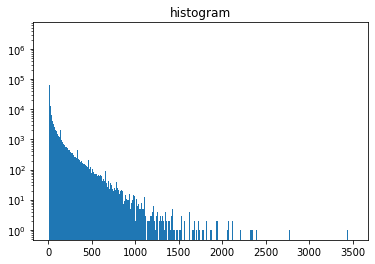

In [141]:
a = band1.flatten()
plt.hist(a, 3250,range=[0,3500], log=True) 
plt.title("histogram") 
plt.show()

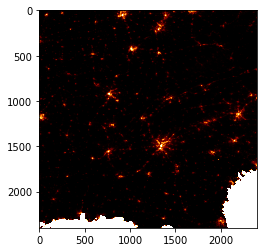

In [142]:
pyplot.imshow(src.read(1), cmap='afmhot', vmax=750)
pyplot.show()

In [143]:
print(src.read(1).shape)

(2400, 2400)


### Check the GeoJSON data

In [144]:
gdf
#gdf.to_crs(epsg=4326) can be used to convert to the relevant representation
#print(type(gdf['geometry']))

,mine_id,datetime,pngfilename,tiffilename,labeler,polygonlabel,geometry
0,10324,2020-11-07 16:23:02,10324_004_20201107T162302.png,10324/10324__S2B-MSIL2A-ST20201107T162302-N021...,5,Infrastructure,"POLYGON ((-81.82582 37.68350, -81.82527 37.685..."
1,10324,2020-11-07 16:23:02,10324_004_20201107T162302.png,10324/10324__S2B-MSIL2A-ST20201107T162302-N021...,5,Pit,"POLYGON ((-81.83045 37.68280, -81.83133 37.682..."
2,10324,2020-11-07 16:23:02,10324_004_20201107T162302.png,10324/10324__S2B-MSIL2A-ST20201107T162302-N021...,5,Outline,"POLYGON ((-81.83155 37.68579, -81.83114 37.684..."
3,10324,2020-04-16 16:23:00,10324_003_20200416T162300.png,10324/10324__S2A-MSIL2A-ST20200416T162300-N021...,5,Infrastructure,"POLYGON ((-81.82567 37.68394, -81.82521 37.684..."
4,10324,2020-04-16 16:23:00,10324_003_20200416T162300.png,10324/10324__S2A-MSIL2A-ST20200416T162300-N021...,5,Pit,"POLYGON ((-81.83128 37.68248, -81.83235 37.681..."
5,10324,2020-04-16 16:23:00,10324_003_20200416T162300.png,10324/10324__S2A-MSIL2A-ST20200416T162300-N021...,5,Outline,"POLYGON ((-81.83095 37.68580, -81.83087 37.683..."


<AxesSubplot:>

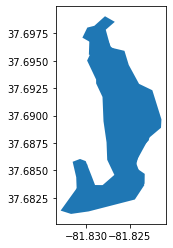

In [145]:
#for mva purposes only keep the outline polygons
gdf_redu = gdf[gdf['polygonlabel']=='Outline']
gdf_redu = gdf_redu.set_geometry("geometry")
boroughs_4326 = gdf_redu.to_crs("EPSG:4326")
boroughs_4326.plot()
#boroughs_4326.crs

In [146]:
for i in gdf_redu[['geometry']].values.flatten():
    print(i)

POLYGON ((-81.83154932622769 37.68579072342972, -81.8311379652604 37.68437885162946, -81.83107295398553 37.682984187273725, -81.83180409586406 37.68203585084264, -81.83127901054907 37.681509013626545, -81.83043517776034 37.68122021444153, -81.82989676885894 37.68171524512842, -81.82463945102248 37.68251846050819, -81.82326911494789 37.68380526054337, -81.82325416481679 37.68468959786581, -81.82432378067483 37.68527161442312, -81.82377318314623 37.68690637994361, -81.82279334765191 37.68773850436153, -81.82219758855734 37.689766569307956, -81.8230651269843 37.689957013256084, -81.82295735415785 37.69139218628386, -81.82407477639651 37.691816673588626, -81.82430513567225 37.692522448874215, -81.82478428197598 37.693364030822174, -81.82573214794839 37.694104081337436, -81.82544141139702 37.69533679003435, -81.82716324787097 37.69626625322553, -81.82785879417567 37.69754551283945, -81.82962505984885 37.696842644209454, -81.82968303937679 37.69554763389756, -81.82805009719416 37.69521388513

(1, 2400, 2400)
(2400, 2400)


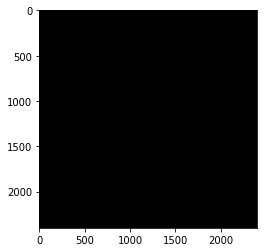

In [147]:
masked_raster, masked_raster_transform = rasterio.mask.mask(src, gdf_redu[['geometry']].values.flatten())
print(masked_raster.shape)
masked_raster = masked_raster[0][:][:]
print(masked_raster.shape)
pyplot.imshow(masked_raster, cmap='afmhot', vmax=10)
pyplot.show()

In [148]:
np.unique(masked_raster)

array([ 0,  7, 16, 24, 42, 62, 69], dtype=uint16)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


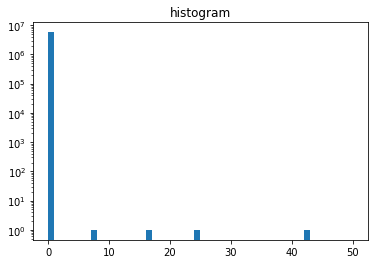

220


In [149]:
#np.set_printoptions(threshold=np.inf) #---> used to view the entire text editor
#np.set_printoptions(threshold=1000) #---> used to reset view options
print(masked_raster)

a = masked_raster.flatten()
plt.hist(a, 50,range=[0,50], log=True) 
plt.title("histogram") 
plt.show()

print(np.sum(masked_raster))